In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

In [4]:
class CryptoBubbleDetector:
    def __init__(self, price_data):
        """
        Initialize the bubble detector with price data.

        Parameters:
        -----------
        price_data : pandas.DataFrame
            DataFrame containing cryptocurrency price data with
            columns: 'date', 'price', 'volume'
        """
        self.price_data = price_data.copy()
        self.price_data['log_price'] = np.log(self.price_data['Close'])

    def exponential_trend_test(self, window=90, threshold_std=2):
        """
        Detect bubbles using exponential trend deviation test.

        Parameters:
        -----------
        window : int, optional (default=90)
            Rolling window size for trend calculation
        threshold_std : float, optional (default=2)
            Number of standard deviations to consider as a bubble

        Returns:
        --------
        pandas.Series: Boolean series indicating bubble periods
        """
        # Calculate exponential trend
        trend = self.price_data['log_price'].ewm(span=window).mean()

        # Calculate deviation from trend
        deviation = self.price_data['log_price'] - trend
        std_deviation = deviation.rolling(window=window).std()

        # Detect bubbles
        bubbles = np.abs(deviation) > (threshold_std * std_deviation)

        return bubbles

    def price_volume_divergence(self, price_volume_ratio_threshold=3):
        """
        Detect bubbles using price-volume relationship.

        Parameters:
        -----------
        price_volume_ratio_threshold : float, optional (default=3)
            Threshold for abnormal price-volume relationship

        Returns:
        --------
        pandas.Series: Boolean series indicating potential bubble periods
        """
        # Calculate price change and volume change
        self.price_data['price_change'] = self.price_data['Close'].pct_change()
        self.price_data['volume_change'] = self.price_data['Volume'].pct_change()

        # Calculate price-volume ratio
        self.price_data['price_volume_ratio'] = (
            np.abs(self.price_data['price_change']) /
            (self.price_data['volume_change'] + 1e-8)
        )

        # Detect bubbles
        bubbles = self.price_data['price_volume_ratio'] > price_volume_ratio_threshold

        return bubbles

    def recursive_unit_root_test(self, window=180):
        """
        Implement recursive unit root test for bubble detection.

        Parameters:
        -----------
        window : int, optional (default=180)
            Rolling window size for recursive test

        Returns:
        --------
        pandas.Series: Boolean series indicating potential bubble periods
        """
        def adf_test(series):
            """Perform Augmented Dickey-Fuller test"""
            result = sm.tsa.adfuller(series)
            return result[1]  # p-value

        # Initialize bubble detection series
        bubbles = pd.Series(False, index=self.price_data.index)

        # Perform rolling ADF test
        for i in range(window, len(self.price_data)):
            subset = self.price_data['log_price'].iloc[i-window:i]
            p_value = adf_test(subset)

            # Low p-value suggests potential bubble
            bubbles.iloc[i] = p_value < 0.05

        return bubbles

    def combined_bubble_detection(self):
        """
        Combine multiple bubble detection methods.

        Returns:
        --------
        pandas.Series: Comprehensive bubble detection results
        """
        # Apply different bubble detection methods
        exp_trend_bubbles = self.exponential_trend_test()
        price_volume_bubbles = self.price_volume_divergence()
        unit_root_bubbles = self.recursive_unit_root_test()

        # Combine results (bubble detected if at least two methods agree)
        combined_bubbles = (
            exp_trend_bubbles.astype(int) +
            price_volume_bubbles.astype(int) +
            unit_root_bubbles.astype(int)
        ) >= 2

        return combined_bubbles

    def identify_tranquil_periods(self, volatility_window=100, volatility_threshold=0.7):
        """
        Identify periods of market tranquility based on price volatility.

        Parameters:
        -----------
        volatility_window : int, optional (default=30)
            Rolling window size for volatility calculation
        volatility_threshold : float, optional (default=0.5)
            Maximum volatility threshold to be considered a tranquil period

        Returns:
        --------
        pandas.Series: Boolean series indicating tranquil market periods
        """
        # Calculate price returns
        returns = self.price_data['Close'].pct_change()

        # Calculate rolling volatility (standard deviation of returns)
        rolling_volatility = returns.rolling(window=volatility_window).std()

        # Identify tranquil periods (low volatility)
        tranquil_periods = rolling_volatility < volatility_threshold

        # Additional conditions for tranquil periods
        # 1. Consistent low trading volume
        volume_quantile = self.price_data['Volume'].quantile(0.25)
        low_volume = self.price_data['Volume'] < volume_quantile

        # 2. Small price fluctuations
        price_change_threshold = returns.quantile(0.25)
        small_price_changes = np.abs(returns) < price_change_threshold

        # Combine conditions for tranquil periods
        comprehensive_tranquil_periods = (
            tranquil_periods &
            low_volume &
            small_price_changes
        )

        return comprehensive_tranquil_periods

    def market_state_analysis(self):
        """
        Perform comprehensive market state analysis.

        Returns:
        --------
        dict: Market state classification results
        """
        # Detect bubbles
        bubble_periods = self.combined_bubble_detection()

        # Identify tranquil periods
        tranquil_periods = self.identify_tranquil_periods()

        # Classify remaining periods as normal market conditions
        normal_periods = ~(bubble_periods | tranquil_periods)

        # Prepare analysis results
        market_states = pd.DataFrame({
            'bubble': bubble_periods,
            'tranquil': tranquil_periods,
            'normal': normal_periods
        })

        # Calculate market state statistics
        state_analysis = {
            'bubble_percentage': bubble_periods.mean() * 100,
            'tranquil_percentage': tranquil_periods.mean() * 100,
            'normal_percentage': normal_periods.mean() * 100,
            'total_periods': len(market_states)
        }

        return {
            'states': market_states,
            'analysis': state_analysis
        }

    def visualize_bubbles(self, bubbles):
        """
        Visualize price data with detected bubbles.

        Parameters:
        -----------
        bubbles : pandas.Series
            Boolean series indicating bubble periods
        """
        plt.figure(figsize=(15, 8))
        plt.plot(self.price_data.index, self.price_data['Close'], label='Price')

        # Highlight bubble periods
        bubble_periods = self.price_data[bubbles]
        plt.scatter(
            bubble_periods.index,
            bubble_periods['Close'],
            color='red',
            label='Potential Bubble',
            alpha=0.7
        )

        plt.title('Cryptocurrency Price with Detected Bubbles')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

def load_crypto_data(file_path):
    """
    Load cryptocurrency price data from CSV.

    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing price data

    Returns:
    --------
    pandas.DataFrame: Processed cryptocurrency price data
    """
    # Load data
    df = pd.read_csv(file_path, parse_dates=['time'])

    # Basic data cleaning
    df.dropna(inplace=True)
    df.sort_values('time', inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df


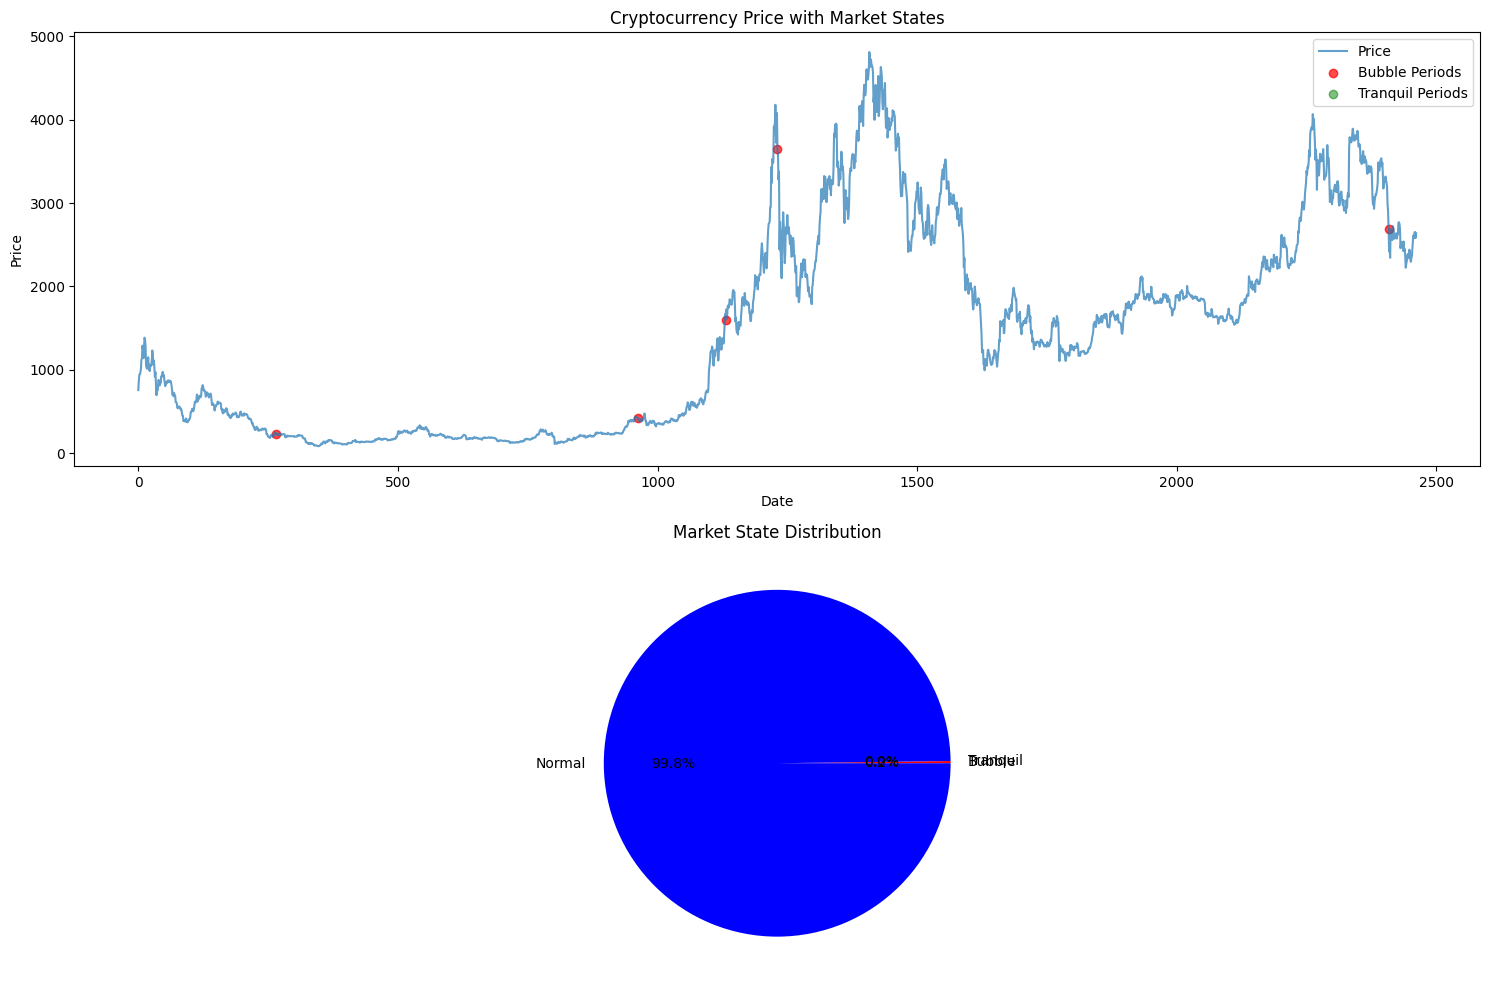


Market State Analysis:
Total Analysis Periods: 2462
Bubble Periods: 0.20%
Tranquil Periods: 0.00%
Normal Market Periods: 99.80%


In [5]:
def main():
    """
    Main function to demonstrate bubble detection process.
    """
    # Load cryptocurrency data
    crypto_data = load_crypto_data('eth.csv')

    # Initialize bubble detector
    detector = CryptoBubbleDetector(crypto_data)

    # Perform comprehensive market state analysis
    market_state_results = detector.market_state_analysis()

    # Visualize market states
    plt.figure(figsize=(15, 10))

    # Price plot with market state coloring
    plt.subplot(2, 1, 1)
    plt.plot(crypto_data.index, crypto_data['Close'], label='Price', alpha=0.7)

    # Color code market states
    states = market_state_results['states']
    price = crypto_data['Close']

    # Highlight bubbles
    bubble_periods = states[states['bubble']].index
    plt.scatter(
        bubble_periods,
        price.loc[bubble_periods],
        color='red',
        label='Bubble Periods',
        alpha=0.7
    )

    # Highlight tranquil periods
    tranquil_periods = states[states['tranquil']].index
    plt.scatter(
        tranquil_periods,
        price.loc[tranquil_periods],
        color='green',
        label='Tranquil Periods',
        alpha=0.5
    )

    plt.title('Cryptocurrency Price with Market States')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()

    # Market state distribution pie chart
    plt.subplot(2, 1, 2)
    state_analysis = market_state_results['analysis']
    plt.pie(
        [
            state_analysis['bubble_percentage'],
            state_analysis['tranquil_percentage'],
            state_analysis['normal_percentage']
        ],
        labels=['Bubble', 'Tranquil', 'Normal'],
        colors=['red', 'green', 'blue'],
        autopct='%1.1f%%'
    )
    plt.title('Market State Distribution')

    plt.tight_layout()
    plt.show()

    # Print detailed market state analysis
    print("\nMarket State Analysis:")
    print(f"Total Analysis Periods: {state_analysis['total_periods']}")
    print(f"Bubble Periods: {state_analysis['bubble_percentage']:.2f}%")
    print(f"Tranquil Periods: {state_analysis['tranquil_percentage']:.2f}%")
    print(f"Normal Market Periods: {state_analysis['normal_percentage']:.2f}%")

    # Detailed statistics for different market states
    def get_state_stats(state_column):
        """Helper function to get statistics for a specific market state"""
        state_periods = crypto_data[market_state_results['states'][state_column]]
        return state_periods['price'].describe()

if __name__ == '__main__':
    main()